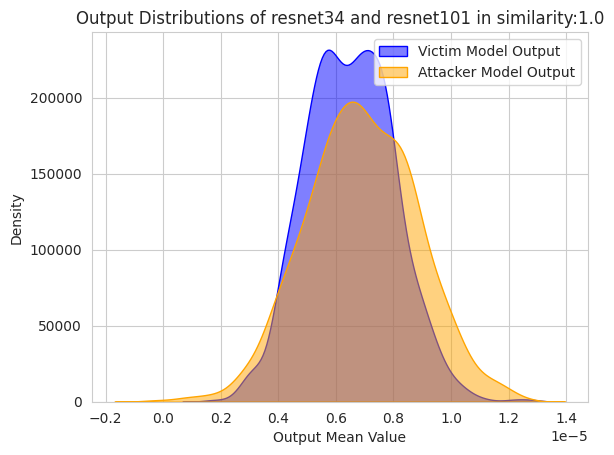

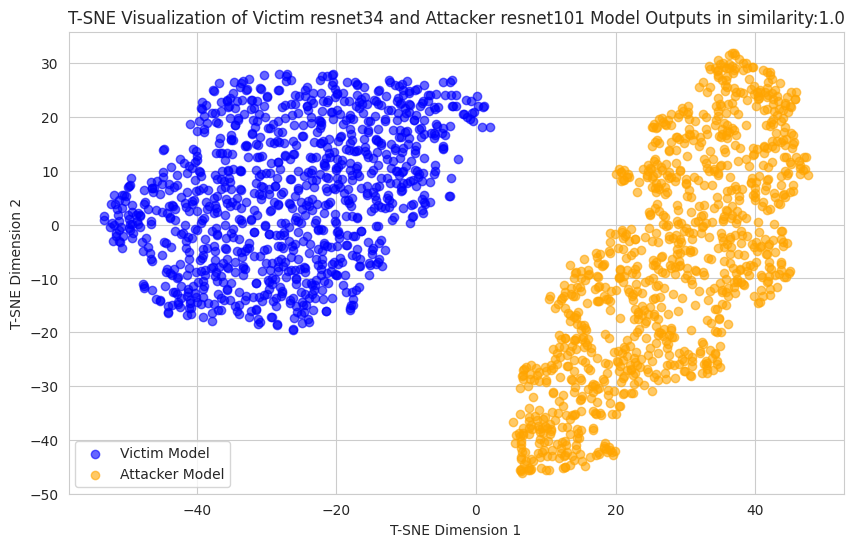

In [10]:
import os
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import get_network
from utils_noise import get_intersection_mean_std
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from conf import settings


def main():
    # 配置参数
    dataset = "cifar100"  # 数据集名称
    victim_model_type = "resnet34"  # 受害者模型
    attacker_model_type = "resnet101"  # 攻击者模型
    inter_propor = 1.0 # 数据集相似度比例
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 动态生成模型路径
    inter_propor_str = f"int{inter_propor}"
    victim_model_path = os.path.join(settings.CHECKPOINT_PATH_NOISE, "noise_similarity", dataset, victim_model_type, inter_propor_str, "model_2.pth")
    attacker_model_path = os.path.join(settings.CHECKPOINT_PATH_NOISE, "noise_similarity", dataset, attacker_model_type, inter_propor_str, "model_2.pth")

    # 获取标准化参数
    mean, std = get_intersection_mean_std(dataset, inter_propor)

    # 加载受害者模型
    victim_net = get_network(dataset, victim_model_type, False)
    victim_net.load_state_dict(torch.load(victim_model_path, map_location=device))
    victim_net = victim_net.to(device)  # 将模型移动到 GPU
    victim_net.eval()

    # 加载攻击者模型
    attacker_net = get_network(dataset, attacker_model_type, False)
    attacker_net.load_state_dict(torch.load(attacker_model_path, map_location=device))
    attacker_net = attacker_net.to(device)  # 将模型移动到 GPU
    attacker_net.eval()

    # 包装模型以应用标准化
    normalize = transforms.Normalize(mean, std)
    victim_model = nn.Sequential(normalize.to(device), victim_net)
    attacker_model = nn.Sequential(normalize.to(device), attacker_net)

    # 生成测试数据（CIFAR-10 示例）
    input_data = torch.randn(1000, 3, 32, 32).to(device)  # 1000 个样本

    # 推理模型并获取输出
    with torch.no_grad():
        victim_outputs = victim_model(input_data).cpu().numpy()
        attacker_outputs = attacker_model(input_data).cpu().numpy()

    # 处理输出分布（例如，计算均值）
    victim_output_mean = np.mean(victim_outputs, axis=1)
    attacker_output_mean = np.mean(attacker_outputs, axis=1)

    # 可视化分布
    sns.kdeplot(victim_output_mean, label="Victim Model Output", fill=True, color="blue", alpha=0.5)
    sns.kdeplot(attacker_output_mean, label="Attacker Model Output", fill=True, color="orange", alpha=0.5)

    # 使用 T-SNE 降维
    victim_outputs_flat = victim_outputs.reshape(victim_outputs.shape[0], -1)  # 展平成二维
    attacker_outputs_flat = attacker_outputs.reshape(attacker_outputs.shape[0], -1)  # 展平成二维
    # 合并输出用于 T-SNE
    all_outputs = np.concatenate([victim_outputs_flat, attacker_outputs_flat], axis=0)
    labels = np.array([0] * victim_outputs_flat.shape[0] + [1] * attacker_outputs_flat.shape[0])  # 0 表示受害者，1 表示攻击者

    # 应用 T-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    outputs_2d = tsne.fit_transform(all_outputs)

    plt.legend()
    plt.title(f"Output Distributions of {victim_model_type} and {attacker_model_type} in similarity:{inter_propor}")
    plt.xlabel("Output Mean Value")
    plt.ylabel("Density")
    plt.show()

    # T-SNE 可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(outputs_2d[labels == 0, 0], outputs_2d[labels == 0, 1], label="Victim Model", alpha=0.6, c="blue")
    plt.scatter(outputs_2d[labels == 1, 0], outputs_2d[labels == 1, 1], label="Attacker Model", alpha=0.6, c="orange")
    plt.legend()
    plt.title(f"T-SNE Visualization of Victim {victim_model_type} and Attacker {attacker_model_type} Model Outputs in similarity:{inter_propor}")
    plt.xlabel("T-SNE Dimension 1")
    plt.ylabel("T-SNE Dimension 2")
    plt.grid(True)
    plt.show()

    # 删除不需要的变量以释放内存
    del victim_outputs, attacker_outputs, victim_model, attacker_model
    del victim_net, attacker_net, input_data, outputs_2d
    torch.cuda.empty_cache()  # 清理 GPU 内存

if __name__ == "__main__":
    main()